In [2]:
import numpy as np
import pandas as pd
from IPython.display import display

nypd_data = pd.read_csv("data/NYPD_Complaint_Data_Historic_20240528.csv",low_memory=False)

# Cleaning data

### Options of populating CMPLNT_FR_DT
1. We just take datetime from CMPLT_TO_DT if difference in hours is not bigger than some threeshold
    - but what if fr_tm and to_tm are the same? Do we really can populate with same date? 
2. Other option we can just populate it with report date 

len(nypd_data[nypd_data['RPT_DT'].isna()]) # 0

len(nypd_data[nypd_data['RPT_DT'] == '(null)']) # 0

rpt date is always non null

In [3]:
# First option
threshold_hours = 24

def is_time_difference_within_threshold(start_time, end_time, threshold_hours):
    start = pd.to_datetime(start_time, format='%H:%M:%S', errors='coerce')
    end = pd.to_datetime(end_time, format='%H:%M:%S', errors='coerce')
    
    if pd.isna(start) or pd.isna(end):
        return False
    time_diff = (end - start).total_seconds() / 3600.0
    return time_diff <= threshold_hours


mask = nypd_data['CMPLNT_FR_DT'].isna() & nypd_data['CMPLNT_TO_DT'].notnull()

def fill_cmplnt_fr_dt(row, threshold_hours):
    if is_time_difference_within_threshold(row['CMPLNT_FR_TM'], row['CMPLNT_TO_TM'], threshold_hours):
        return row['CMPLNT_TO_DT']
    return row['CMPLNT_FR_DT']

nypd_data.loc[mask, 'CMPLNT_FR_DT'] = nypd_data[mask].apply(fill_cmplnt_fr_dt, threshold_hours=threshold_hours, axis=1)

In [4]:
# Second option
mask = nypd_data['CMPLNT_FR_DT'].isna()
nypd_data.loc[mask, 'CMPLNT_FR_DT'] = nypd_data['RPT_DT']

In [5]:
len(nypd_data[nypd_data['CMPLNT_FR_DT'].isna()])

0

### Cleaning CMPLNT_FR_TM

In [6]:
rows_to_drop = nypd_data[nypd_data['CMPLNT_FR_TM'] == '(null)'].index

nypd_data.drop(rows_to_drop, inplace=True)

### Cleaning CMPLNT_TO_TM
I dont think we really need those rows, maybe only for plotting, but even then i would just drop them

In [7]:
nypd_data.dropna(subset=['CMPLNT_TO_TM'], inplace=True)

### Filling both to_dt and fr_dt with rpt_dt if they are null

In [8]:
mask = nypd_data['CMPLNT_FR_DT'].isnull() & nypd_data['CMPLNT_TO_DT'].isnull()

nypd_data.loc[mask, 'CMPLNT_FR_DT'] = nypd_data.loc[mask, 'RPT_DT']
nypd_data.loc[mask, 'CMPLNT_TO_DT'] = nypd_data.loc[mask, 'RPT_DT']

In [9]:
null_to_dt = nypd_data[nypd_data["CMPLNT_TO_DT"].isna()]
starting_dt = null_to_dt[null_to_dt['CMPLNT_FR_DT'].isna()]
len(starting_dt)

0

## Cleaning OFNS_DESC

1. First we get all unique codes when OFNS_DESC is null
2. We create a map based on those codes and their OFNS_DESC from other rows
3. We populate original dataset with those values

In [10]:
ky_cd_for_null_offns_desc = nypd_data[nypd_data['OFNS_DESC'] == '(null)']['KY_CD'].unique()
ky_cd_to_ofns_desc = nypd_data[nypd_data['OFNS_DESC'] != '(null)'].set_index('KY_CD')['OFNS_DESC'].to_dict()
nypd_data.loc[nypd_data['OFNS_DESC'] == '(null)', 'OFNS_DESC'] = nypd_data['KY_CD'].map(ky_cd_to_ofns_desc)

### Cleaning ADDR_PCT_CD 
Maybe we can get this using some external api based on long and lat if needed
currently will just drop them

In [11]:
nypd_data.dropna(subset=['ADDR_PCT_CD'], inplace=True)

### Cleaning of PD_CD

Clearing PD_CD

PD_CD is nan when ky_cd is 101 (ofns_desc is MURDER & NON-NEGL. MANSLAUGHTER	)

My idea is that we create a new pd_cd code and give it the same description as in ofns_desc based on ky_cd (101)

In [12]:
new_code = 976
description = 'MURDER & NON-NEGL. MANSLAUGHTER'
nypd_data.loc[nypd_data['PD_CD'].isna(), 'PD_CD'] = new_code
mask = nypd_data['PD_DESC'] == '(null)'
nypd_data.loc[mask, 'PD_DESC'] = description

### Cleaning CRM_ATPT_CPTD_CD 

I think we should just drop crimes that were neither completed nor attempted, it is only .0018% of actual dataset

In [13]:
nypd_data.dropna(subset=['CRM_ATPT_CPTD_CD'], inplace=True)
rows_to_drop = nypd_data[nypd_data['CRM_ATPT_CPTD_CD'] == '(null)'].index

nypd_data.drop(rows_to_drop, inplace=True)

### Cleaning BORO_NM
i think we should just drop those row, it will take great effort to populate this column with data using x/y coordinates
or latitude and longtude.

In [14]:
rows_to_drop = nypd_data[nypd_data['BORO_NM'] == '(null)'].index

nypd_data.drop(rows_to_drop, inplace=True)

### Cleaning `LOC_OF_OCCUR_DESC` 
I will populate this with `OUTSIDE` value if PARKS_NM is not null
Otherwise with `INSIDE`

In [15]:
# First is outside
mask_parks = nypd_data['PARKS_NM'] != '(null)'
mask_loc = nypd_data['LOC_OF_OCCUR_DESC'] == '(null)'
final_mask = mask_parks & mask_loc
nypd_data.loc[final_mask, 'LOC_OF_OCCUR_DESC'] = 'OUTSIDE'

In [16]:
# Everything else with INSIDE
mask = nypd_data['LOC_OF_OCCUR_DESC'] == '(null)'
mask_nan = nypd_data['LOC_OF_OCCUR_DESC'].isna()
nypd_data.loc[mask, 'LOC_OF_OCCUR_DESC'] = 'INSIDE' 
nypd_data.loc[mask_nan, 'LOC_OF_OCCUR_DESC'] = 'INSIDE' 

### Cleaning `PREM_TYP_DESC`
I would just populate all 39k null values with the most frequent label

In [17]:
most_frequent = nypd_data['PREM_TYP_DESC'].value_counts(dropna=False).idxmax()
mask = nypd_data['PREM_TYP_DESC'] == '(null)'
nypd_data.loc[mask, 'PREM_TYP_DESC'] = most_frequent

### Cleaning `PARKS_NM`

In [18]:
# I will just replace with unknown that could mean either we really dont know the name or accident occured inside 
mask = nypd_data['PARKS_NM'] == '(null)'
nypd_data.loc[mask, 'PARKS_NM'] = 'UNKNOWN'

### Cleaning `HADEVELOPT`

In [19]:
mask = nypd_data['HADEVELOPT'] == '(null)'
nypd_data.loc[mask, 'HADEVELOPT'] = 'UNKNOWN'

### Cleaning `HOUSING_PSA`

In [20]:
mask = nypd_data['HOUSING_PSA'] == '(null)'
nypd_data.loc[mask, 'HOUSING_PSA'] = 'UNKNOWN'

### Cleaning `SUSP_AGE_GROUP`

In [21]:
correct_age_groups = ['<18', '18-24', '25-44', '45-64', '65+', 'UNKNOWN']
all_age_groups = nypd_data['SUSP_AGE_GROUP'].unique()
age_groups_to_change = [item for item in all_age_groups if item not in correct_age_groups]
nypd_data.loc[nypd_data['SUSP_AGE_GROUP'].isin(age_groups_to_change), 'SUSP_AGE_GROUP'] = 'UNKNOWN'
nypd_data['SUSP_AGE_GROUP'].unique()

array(['UNKNOWN', '<18', '25-44', '18-24', '45-64', '65+'], dtype=object)

### Cleaning `SUSP_RACE`

In [22]:
mask = nypd_data['SUSP_RACE'] == '(null)'
nypd_data.loc[mask, 'SUSP_RACE'] = 'UNKNOWN'

### Cleaning `SUSP_SEX`

In [23]:
mask = nypd_data['SUSP_SEX'] == '(null)'
nypd_data.loc[mask, 'SUSP_SEX'] = 'U'

### Cleaning PATROL_BORO

maybe we should add some randomness so that it is not alway south/north but randomly changes 

In [24]:
map_boro_to_patrol_boro = {
    'MANHATTAN': 'PATROL BORO MAN SOUTH',
    'BROOKLYN': 'PATROL BORO BKLYN NORTH',
    'BRONX': 'PATROL BORO BRONX',
    'QUEENS': 'PATROL BORO QUEENS NORTH',
    'STATEN ISLAND' : 'PATROL BORO STATEN ISLAND'
}
mask = nypd_data['PATROL_BORO'] == '(null)'
nypd_data.loc[mask, 'PATROL_BORO'] = nypd_data[mask].apply(
    lambda row: map_boro_to_patrol_boro.get(row['BORO_NM'], row['PATROL_BORO']),
    axis=1
)
nypd_data['PATROL_BORO'].unique()

array(['PATROL BORO BKLYN NORTH', 'PATROL BORO MAN NORTH',
       'PATROL BORO BKLYN SOUTH', 'PATROL BORO BRONX',
       'PATROL BORO MAN SOUTH', 'PATROL BORO QUEENS NORTH',
       'PATROL BORO QUEENS SOUTH', 'PATROL BORO STATEN ISLAND'],
      dtype=object)

### Cleaning `TRANSIT_DISTRICT`
In simple terms it refers to transit areas such as subways and other transportation
We will replace it with 0, meaning crime didn`t occur in transit district

In [25]:
mask = nypd_data['TRANSIT_DISTRICT'].isna()
nypd_data.loc[mask, 'TRANSIT_DISTRICT'] = 0

### Cleaning `STATION_NAME`
I will replace it with Unknown, i dont really believe we will need this feature anyway

In [26]:
mask = nypd_data['STATION_NAME'] == '(null)'
nypd_data.loc[mask, 'STATION_NAME'] = 'UNKNOWN'

### Cleaning `VIC_AGE_GROUP`

In [27]:
correct_age_groups = ['<18', '18-24', '25-44', '45-64', '65+', 'UNKNOWN']
all_age_groups = nypd_data['VIC_AGE_GROUP'].unique()
age_groups_to_change = [item for item in all_age_groups if item not in correct_age_groups]
nypd_data.loc[nypd_data['VIC_AGE_GROUP'].isin(age_groups_to_change), 'VIC_AGE_GROUP'] = 'UNKNOWN'
nypd_data['VIC_AGE_GROUP'].unique()

array(['25-44', '45-64', 'UNKNOWN', '18-24', '<18', '65+'], dtype=object)

### Cleaning `VIC_RACE`

In [28]:
mask = nypd_data['VIC_RACE'] == '(null)'
nypd_data.loc[mask, 'VIC_RACE'] = 'UNKNOWN'

### Cleaning `VIC_SEX`

In [29]:
mask = nypd_data['VIC_SEX'] == '(null)'
nypd_data.loc[mask, 'VIC_SEX'] = 'U'

Split dataset into some chunks, first is where every value exists, second is some null values but we can replace them by other means
and other is when we have null but no idea how to fill it

In [30]:
nypd_data_nonnull_time = nypd_data[(nypd_data['CMPLNT_TO_DT'].notna()) & (nypd_data['CMPLNT_TO_TM'] != '(null)')]

nypd_data_null_time = nypd_data[nypd_data['CMPLNT_TO_DT'].isna() | (nypd_data['CMPLNT_TO_TM'] == '(null)')]
nypd_data_null_time = nypd_data_nonnull_time.drop_duplicates()

Checking for null values:

In [31]:
for column in nypd_data_nonnull_time.columns:
    null_count = nypd_data_nonnull_time[column].isnull().sum()
    print(f"Column '{column}' has {null_count} null values.")

Column 'CMPLNT_NUM' has 0 null values.
Column 'CMPLNT_FR_DT' has 0 null values.
Column 'CMPLNT_FR_TM' has 0 null values.
Column 'CMPLNT_TO_DT' has 0 null values.
Column 'CMPLNT_TO_TM' has 0 null values.
Column 'ADDR_PCT_CD' has 0 null values.
Column 'RPT_DT' has 0 null values.
Column 'KY_CD' has 0 null values.
Column 'OFNS_DESC' has 0 null values.
Column 'PD_CD' has 0 null values.
Column 'PD_DESC' has 0 null values.
Column 'CRM_ATPT_CPTD_CD' has 0 null values.
Column 'LAW_CAT_CD' has 0 null values.
Column 'BORO_NM' has 0 null values.
Column 'LOC_OF_OCCUR_DESC' has 0 null values.
Column 'PREM_TYP_DESC' has 0 null values.
Column 'JURIS_DESC' has 0 null values.
Column 'JURISDICTION_CODE' has 0 null values.
Column 'PARKS_NM' has 0 null values.
Column 'HADEVELOPT' has 0 null values.
Column 'HOUSING_PSA' has 0 null values.
Column 'X_COORD_CD' has 0 null values.
Column 'Y_COORD_CD' has 0 null values.
Column 'SUSP_AGE_GROUP' has 0 null values.
Column 'SUSP_RACE' has 0 null values.
Column 'SUSP

In [32]:
for column in nypd_data_nonnull_time.columns:
    null_count = len(nypd_data_nonnull_time[nypd_data_nonnull_time[column] == '(null)'])
    print(f"Column '{column}' has {null_count} null values.")

Column 'CMPLNT_NUM' has 0 null values.
Column 'CMPLNT_FR_DT' has 0 null values.
Column 'CMPLNT_FR_TM' has 0 null values.
Column 'CMPLNT_TO_DT' has 0 null values.
Column 'CMPLNT_TO_TM' has 0 null values.
Column 'ADDR_PCT_CD' has 0 null values.
Column 'RPT_DT' has 0 null values.
Column 'KY_CD' has 0 null values.
Column 'OFNS_DESC' has 0 null values.
Column 'PD_CD' has 0 null values.
Column 'PD_DESC' has 0 null values.
Column 'CRM_ATPT_CPTD_CD' has 0 null values.
Column 'LAW_CAT_CD' has 0 null values.
Column 'BORO_NM' has 0 null values.
Column 'LOC_OF_OCCUR_DESC' has 0 null values.
Column 'PREM_TYP_DESC' has 0 null values.
Column 'JURIS_DESC' has 0 null values.
Column 'JURISDICTION_CODE' has 0 null values.
Column 'PARKS_NM' has 0 null values.
Column 'HADEVELOPT' has 0 null values.
Column 'HOUSING_PSA' has 0 null values.
Column 'X_COORD_CD' has 0 null values.
Column 'Y_COORD_CD' has 0 null values.
Column 'SUSP_AGE_GROUP' has 0 null values.
Column 'SUSP_RACE' has 0 null values.
Column 'SUSP

# Data Visualization

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Location of Crimes

<ipython-input-34-366b025fccfc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_counts.index, y=location_counts.values, palette='viridis')


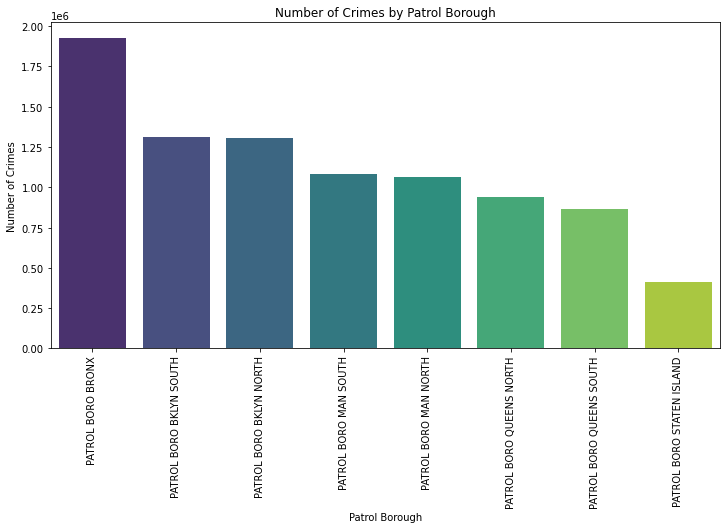

In [34]:
plt.figure(figsize=(12, 6))
location_counts = nypd_data['PATROL_BORO'].value_counts()
sns.barplot(x=location_counts.index, y=location_counts.values, palette='viridis')
plt.title('Number of Crimes by Patrol Borough')
plt.xlabel('Patrol Borough')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=90)
plt.show()

### Types of crimes

<ipython-input-35-5908bf71441b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=offense_counts.index, y=offense_counts.values, palette='magma')


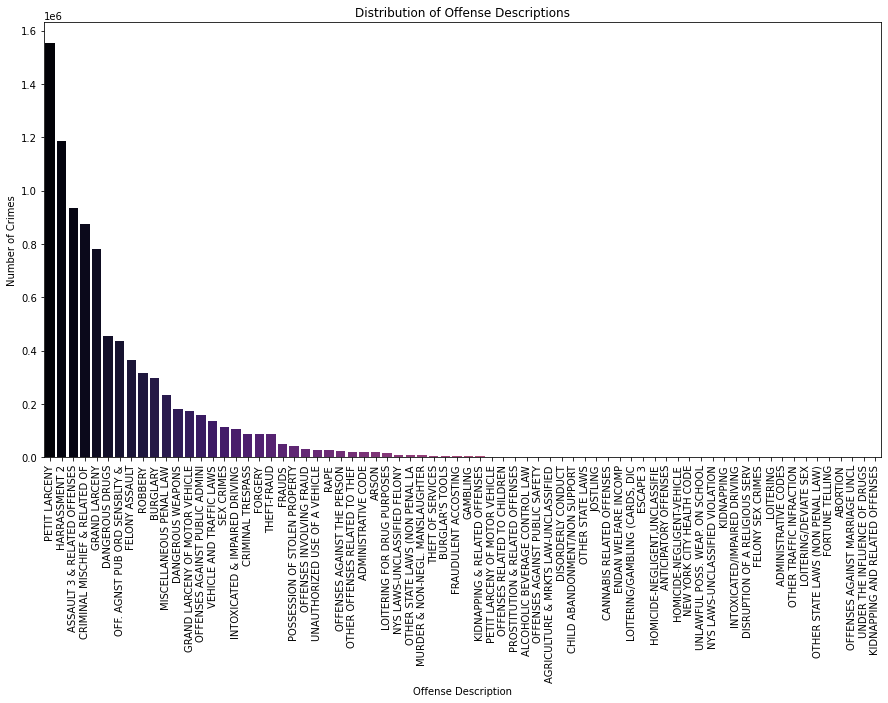

In [35]:
plt.figure(figsize=(15, 8))
offense_counts = nypd_data['OFNS_DESC'].value_counts()
sns.barplot(x=offense_counts.index, y=offense_counts.values, palette='magma')
plt.title('Distribution of Offense Descriptions')
plt.xlabel('Offense Description')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=90)
plt.show()

### Amount of crimes through the year

In [36]:
nypd_data['CMPLNT_FR_DT'] = pd.to_datetime(nypd_data['CMPLNT_FR_DT'], errors='coerce')

nypd_data['Month'] = nypd_data['CMPLNT_FR_DT'].dt.month
nypd_data['Season'] = nypd_data['CMPLNT_FR_DT'].dt.month % 12 // 3 + 1
nypd_data['Season'] = nypd_data['Season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})

Due to huge amount of diffrent crimes we decided to categorize them:

Theft-related crimes: BURGLARY, GRAND LARCENY, PETIT LARCENY, ROBBERY, GRAND LARCENY OF MOTOR VEHICLE, PETIT LARCENY OF MOTOR VEHICLE, POSSESSION OF STOLEN PROPERTY, THEFT OF SERVICES.

Assault-related crimes: FELONY ASSAULT, ASSAULT 3 & RELATED OFFENSES.

Drug-related crimes: INTOXICATED & IMPAIRED DRIVING, DANGEROUS DRUGS, LOITERING FOR DRUG PURPOSES, INTOXICATED/IMPAIRED DRIVING, CANNABIS RELATED OFFENSES.

Sexual crimes: RAPE, SEX CRIMES, FELONY SEX CRIMES, KIDNAPPING & RELATED OFFENSES, KIDNAPPING, KIDNAPPING AND RELATED OFFENSES.

Other categories: OFFENSES AGAINST THE PERSON, OFFENSES AGAINST PUBLIC ADMINI, DISORDERLY CONDUCT, OFFENSES INVOLVING FRAUD, PROSTITUTION & RELATED OFFENSES, HOMICIDE-NEGLIGENT-VEHICLE, MURDER & NON-NEGL. MANSLAUGHTER, etc.


In [37]:
crime_mapping = {
    'Theft-related': ['BURGLARY', 'GRAND LARCENY', 'PETIT LARCENY', 'ROBBERY', 'GRAND LARCENY OF MOTOR VEHICLE', 'PETIT LARCENY OF MOTOR VEHICLE', 'POSSESSION OF STOLEN PROPERTY', 'THEFT OF SERVICES'],
    'Assault-related': ['FELONY ASSAULT', 'ASSAULT 3 & RELATED OFFENSES'],
    'Drug-related': ['INTOXICATED & IMPAIRED DRIVING', 'DANGEROUS DRUGS', 'LOITERING FOR DRUG PURPOSES', 'INTOXICATED/IMPAIRED DRIVING', 'CANNABIS RELATED OFFENSES'],
    'Sexual crimes': ['RAPE', 'SEX CRIMES', 'FELONY SEX CRIMES', 'KIDNAPPING & RELATED OFFENSES', 'KIDNAPPING', 'KIDNAPPING AND RELATED OFFENSES'],
    'Other': ['OFFENSES AGAINST THE PERSON', 'OFFENSES AGAINST PUBLIC ADMINI', 'DISORDERLY CONDUCT', 'OFFENSES INVOLVING FRAUD', 'PROSTITUTION & RELATED OFFENSES', 'HOMICIDE-NEGLIGENT-VEHICLE', 'MURDER & NON-NEGL. MANSLAUGHTER']
}

<ipython-input-38-af7b6afa92e6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_crime_counts.index, y=month_crime_counts.values, palette='tab20', ax=axes[0])
<ipython-input-38-af7b6afa92e6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_crime_counts.index, y=season_crime_counts.values, palette='pastel', ax=axes[1])


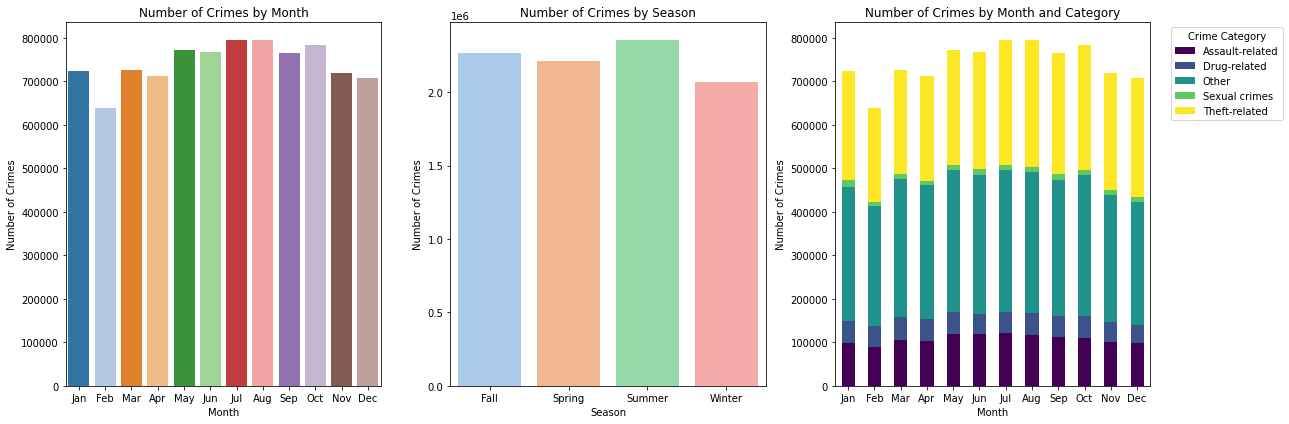

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

month_crime_counts = nypd_data['Month'].value_counts().sort_index()
sns.barplot(x=month_crime_counts.index, y=month_crime_counts.values, palette='tab20', ax=axes[0])
axes[0].set_title('Number of Crimes by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Crimes')
axes[0].set_xticks(range(12))
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

season_crime_counts = nypd_data['Season'].value_counts().sort_index()
sns.barplot(x=season_crime_counts.index, y=season_crime_counts.values, palette='pastel', ax=axes[1])
axes[1].set_title('Number of Crimes by Season')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Number of Crimes')



monthly_crime_category = nypd_data.groupby(['Month', nypd_data['OFNS_DESC'].apply(lambda x: next((k for k, v in crime_mapping.items() if x in v), 'Other'))]).size().unstack(fill_value=0)
monthly_crime_category.plot(kind='bar', stacked=True, colormap='viridis', ax=axes[2])
axes[2].set_title('Number of Crimes by Month and Category')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Number of Crimes')
axes[2].set_xticks(range(12))
axes[2].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
axes[2].legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

To check the Jurisdiction code we took top 10 highest values except the highest one N.Y POLICE DEPT with value of almost 8 milion. Thanks to that the graph looks clear.


<ipython-input-39-740eff1e7b1f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=jurisdiction_crime_counts.index, y=jurisdiction_crime_counts.values, palette='viridis', ax=ax)


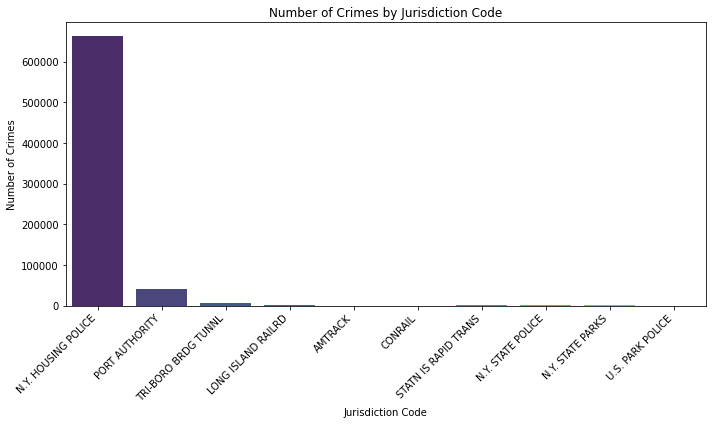

In [39]:
juris_desc_mapping = dict(zip(nypd_data['JURISDICTION_CODE'].unique(), nypd_data['JURIS_DESC'].unique()))


jurisdiction_crime_counts = nypd_data['JURISDICTION_CODE'].value_counts().sort_index()[2:12]


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=jurisdiction_crime_counts.index, y=jurisdiction_crime_counts.values, palette='viridis', ax=ax)
ax.set_title('Number of Crimes by Jurisdiction Code')
ax.set_xlabel('Jurisdiction Code')
ax.set_ylabel('Number of Crimes')


ax.set_xticks(range(len(jurisdiction_crime_counts)))
ax.set_xticklabels([juris_desc_mapping.get(i, 'Unknown') for i in jurisdiction_crime_counts.index], rotation=45, ha='right')

plt.tight_layout()
plt.show()

Also it would be usefull insformation to know where the crime happened

The are values like in front of, opposite of, rear of, these are counted as outside, because they were connected parks or streets etc. For example in fron of "Name" park.

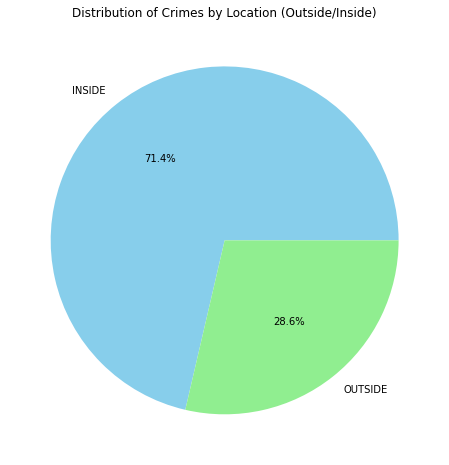

In [47]:
nypd_data_copy = nypd_data.copy()


nypd_data_copy.loc[nypd_data_copy['LOC_OF_OCCUR_DESC'] != 'INSIDE', 'LOC_OF_OCCUR_DESC'] = 'OUTSIDE'

loc_crime_counts = nypd_data_copy['LOC_OF_OCCUR_DESC'].value_counts()


plt.figure(figsize=(8, 8))
plt.pie(loc_crime_counts, labels=loc_crime_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Distribution of Crimes by Location (Outside/Inside)')
plt.show()

### Victims and suspects of the crimes

<ipython-input-41-4590177a91de>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=race_counts.index, y=race_counts.values, palette='Set2', ax=axes[0])
<ipython-input-41-4590177a91de>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
<ipython-input-41-4590177a91de>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_counts.index, y=age_counts.values, palette='Set2', ax=axes[1])
<ipython-input-41-4590177a91de>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
<ipython-input-41-4590177a91de>:20: Futur

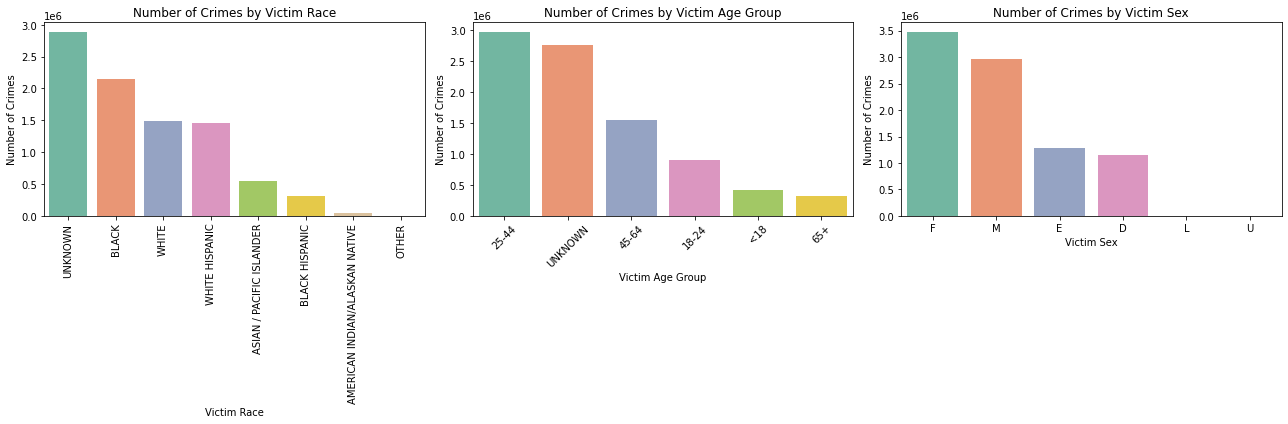

In [41]:
if all(column in nypd_data.columns for column in ['VIC_RACE', 'VIC_AGE_GROUP', 'VIC_SEX']):
  
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    race_counts = nypd_data['VIC_RACE'].value_counts()
    sns.barplot(x=race_counts.index, y=race_counts.values, palette='Set2', ax=axes[0])
    axes[0].set_title('Number of Crimes by Victim Race')
    axes[0].set_xlabel('Victim Race')
    axes[0].set_ylabel('Number of Crimes')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

    age_counts = nypd_data['VIC_AGE_GROUP'].value_counts()
    sns.barplot(x=age_counts.index, y=age_counts.values, palette='Set2', ax=axes[1])
    axes[1].set_title('Number of Crimes by Victim Age Group')
    axes[1].set_xlabel('Victim Age Group')
    axes[1].set_ylabel('Number of Crimes')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

    sex_counts = nypd_data['VIC_SEX'].value_counts()
    sns.barplot(x=sex_counts.index, y=sex_counts.values, palette='Set2', ax=axes[2])
    axes[2].set_title('Number of Crimes by Victim Sex')
    axes[2].set_xlabel('Victim Sex')
    axes[2].set_ylabel('Number of Crimes')

    plt.tight_layout()
    plt.show()
else:
    print("The dataset does not contain information about the victim's race, age, and/or sex.")

<ipython-input-42-6e2c2ccb2de0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=race_counts.index, y=race_counts.values, palette='Set2', ax=axes[0])
<ipython-input-42-6e2c2ccb2de0>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
<ipython-input-42-6e2c2ccb2de0>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_counts.index, y=age_counts.values, palette='Set2', ax=axes[1])
<ipython-input-42-6e2c2ccb2de0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
<ipython-input-42-6e2c2ccb2de0>:22: Futur

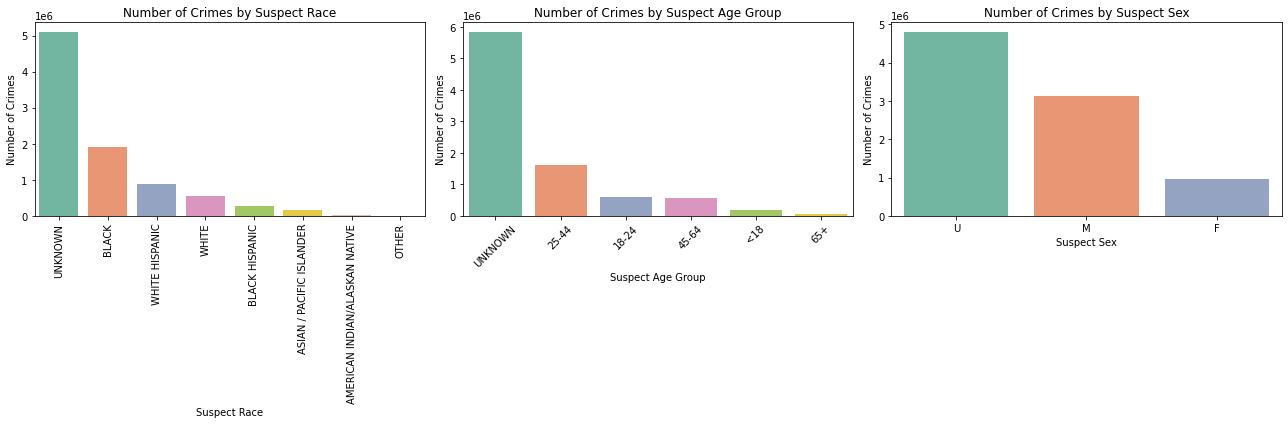

In [42]:
if all(column in nypd_data.columns for column in ['SUSP_RACE', 'SUSP_AGE_GROUP', 'SUSP_SEX']):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

 
    race_counts = nypd_data['SUSP_RACE'].value_counts()
    sns.barplot(x=race_counts.index, y=race_counts.values, palette='Set2', ax=axes[0])
    axes[0].set_title('Number of Crimes by Suspect Race')
    axes[0].set_xlabel('Suspect Race')
    axes[0].set_ylabel('Number of Crimes')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

    
    age_counts = nypd_data['SUSP_AGE_GROUP'].value_counts()
    sns.barplot(x=age_counts.index, y=age_counts.values, palette='Set2', ax=axes[1])
    axes[1].set_title('Number of Crimes by Suspect Age Group')
    axes[1].set_xlabel('Suspect Age Group')
    axes[1].set_ylabel('Number of Crimes')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


    sex_counts = nypd_data['SUSP_SEX'].value_counts()
    sns.barplot(x=sex_counts.index, y=sex_counts.values, palette='Set2', ax=axes[2])
    axes[2].set_title('Number of Crimes by Suspect Sex')
    axes[2].set_xlabel('Suspect Sex')
    axes[2].set_ylabel('Number of Crimes')

    plt.tight_layout()
    plt.show()
else:
    print("The dataset does not contain information about the suspect's race, age, and/or sex.")

### Rape crimes

#### Victims and suspects

<ipython-input-43-5b02a37d39a1>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='VIC_AGE_GROUP', data=rape_victims_df, palette='Set2', ax=axes[0])
<ipython-input-43-5b02a37d39a1>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='VIC_SEX', data=rape_victims_df, palette='Set2', ax=axes[1])
<ipython-input-43-5b02a37d39a1>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='VIC_RACE', data=rape_victims_df, palette='Set2', ax=axes[2])


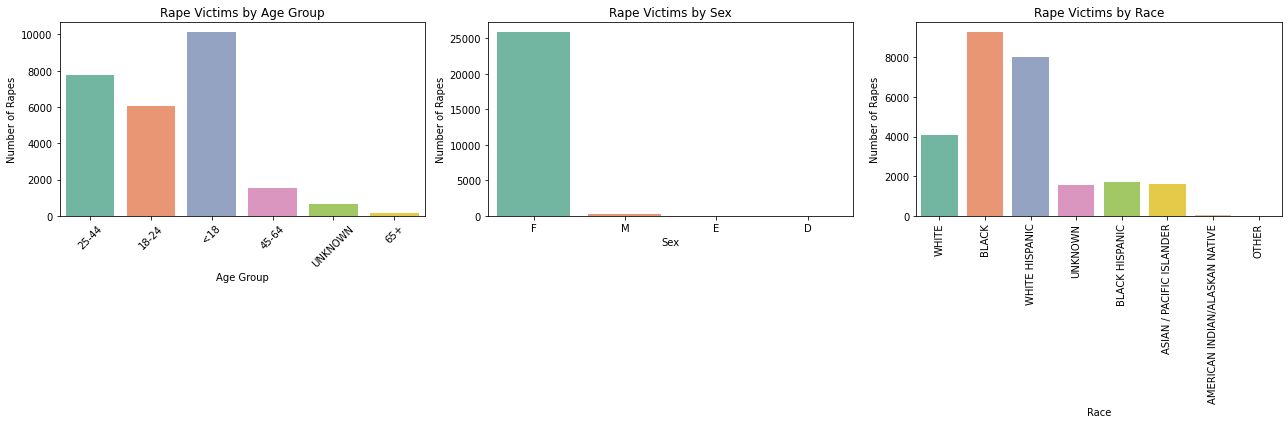

In [43]:
if all(column in nypd_data.columns for column in ['OFNS_DESC', 'VIC_RACE', 'VIC_AGE_GROUP', 'VIC_SEX']):
    
    rape_victims_df = nypd_data[(nypd_data['OFNS_DESC'] == 'RAPE') & (nypd_data['VIC_RACE'].notnull()) & (nypd_data['VIC_AGE_GROUP'].notnull()) & (nypd_data['VIC_SEX'].notnull())]
   

    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

   
    sns.countplot(x='VIC_AGE_GROUP', data=rape_victims_df, palette='Set2', ax=axes[0])
    axes[0].set_title('Rape Victims by Age Group')
    axes[0].set_xlabel('Age Group')
    axes[0].set_ylabel('Number of Rapes')
    axes[0].tick_params(axis='x', rotation=45)

    
    sns.countplot(x='VIC_SEX', data=rape_victims_df, palette='Set2', ax=axes[1])
    axes[1].set_title('Rape Victims by Sex')
    axes[1].set_xlabel('Sex')
    axes[1].set_ylabel('Number of Rapes')

   
    sns.countplot(x='VIC_RACE', data=rape_victims_df, palette='Set2', ax=axes[2])
    axes[2].set_title('Rape Victims by Race')
    axes[2].set_xlabel('Race')
    axes[2].set_ylabel('Number of Rapes')
    axes[2].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

<ipython-input-44-b93c507dcf3c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SUSP_AGE_GROUP', data=rape_suspects_df, palette='Set2', ax=axes2[0])
<ipython-input-44-b93c507dcf3c>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SUSP_SEX', data=rape_suspects_df, palette='Set2', ax=axes2[1])
<ipython-input-44-b93c507dcf3c>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SUSP_RACE', data=rape_suspects_df, palette='Set2', ax=axes2[2])


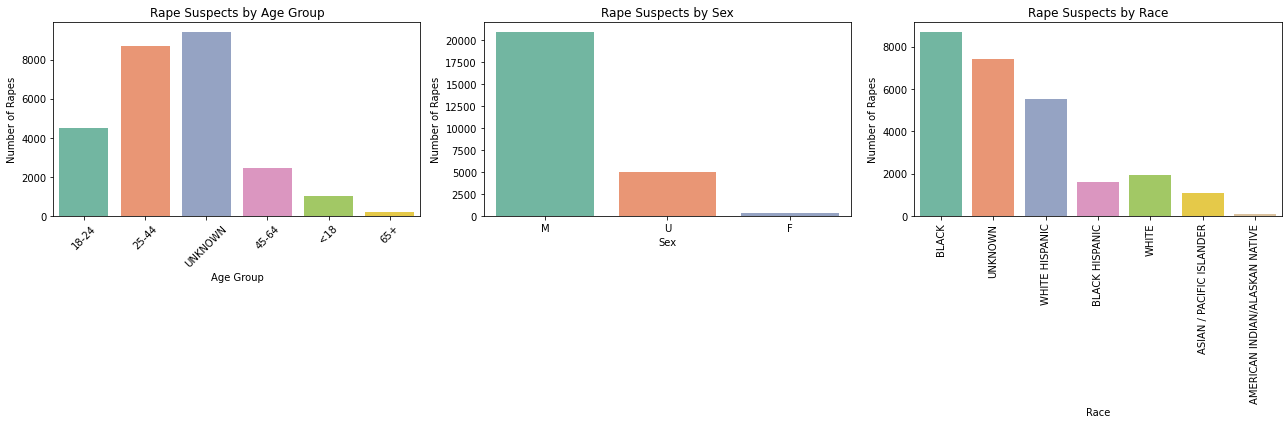

In [44]:
if all(column in nypd_data.columns for column in ['OFNS_DESC','SUSP_RACE', 'SUSP_AGE_GROUP', 'SUSP_SEX']):
    rape_suspects_df = nypd_data[(nypd_data['OFNS_DESC'] == 'RAPE') & (nypd_data['SUSP_RACE'].notnull()) & (nypd_data['SUSP_AGE_GROUP'].notnull()) & (nypd_data['SUSP_SEX'].notnull())]
    
    
    fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))

 
    sns.countplot(x='SUSP_AGE_GROUP', data=rape_suspects_df, palette='Set2', ax=axes2[0])
    axes2[0].set_title('Rape Suspects by Age Group')
    axes2[0].set_xlabel('Age Group')
    axes2[0].set_ylabel('Number of Rapes')
    axes2[0].tick_params(axis='x', rotation=45)


    sns.countplot(x='SUSP_SEX', data=rape_suspects_df, palette='Set2', ax=axes2[1])
    axes2[1].set_title('Rape Suspects by Sex')
    axes2[1].set_xlabel('Sex')
    axes2[1].set_ylabel('Number of Rapes')


    sns.countplot(x='SUSP_RACE', data=rape_suspects_df, palette='Set2', ax=axes2[2])
    axes2[2].set_title('Rape Suspects by Race')
    axes2[2].set_xlabel('Race')
    axes2[2].set_ylabel('Number of Rapes')
    axes2[2].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()
else:
    print("DataFrame does not contain data related to rape.")

#### Location of rape crimes

<ipython-input-45-f11815741d15>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_counts.index, y=region_counts.values, palette='viridis')


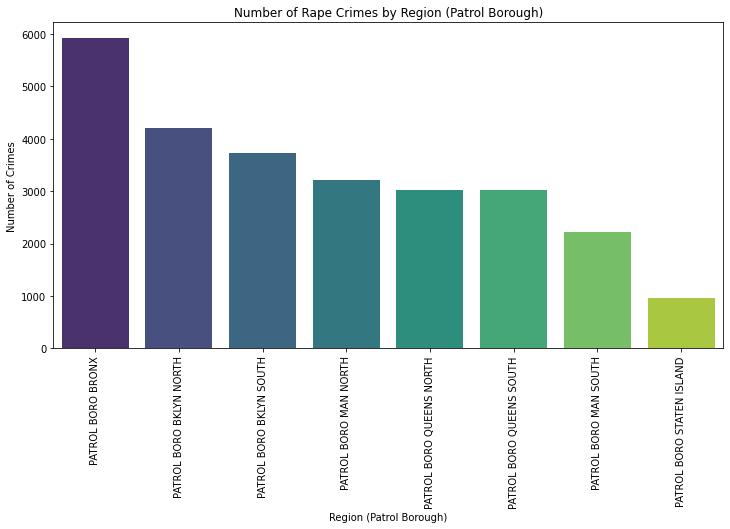

In [45]:
rape_data = nypd_data[nypd_data['OFNS_DESC'] == 'RAPE']
plt.figure(figsize=(12, 6))
region_counts = rape_data['PATROL_BORO'].value_counts()
sns.barplot(x=region_counts.index, y=region_counts.values, palette='viridis')
plt.title('Number of Rape Crimes by Region (Patrol Borough)')
plt.xlabel('Region (Patrol Borough)')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=90)
plt.show()